We use the two different subsets of ShapeStacks during training (cf. Table 1), each one containing an equal amount of stable and unstable images. Both types of violations (VCOM and VPSF, cf. Section 3.2) are evenly represented among unstable images.

During training, we augment the training images by randomising colours, varying aspect-ratios, and applying random cropping, vertical flipping and minimal in-plane rotation. We ensure that all data augmentations still yield physically plausible, upright towers.


In [1]:
import zipfile
import os
import cv2
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# Define your image size and channels
imsize = 224

In [2]:
def getFilenames(rootpath, file, ds = 'train'):
    # Lists to store file data
    filenames = []
    labels = []
    # List file parameters
    meta_list_file = os.path.join(rootpath, file)
    with open(meta_list_file) as f:
        meta_list = f.read().split('\n')
        meta_list.pop(0) # remove trailing empty line
        meta_list.pop(-1)

    for i, meta in enumerate(meta_list):
        if (i+1) % 1000 == 0 or i+1 == len(meta_list):
            print("%s / %s : %s" % (i+1, len(meta_list), meta))
        rec = meta.split(',')
        filenames.append(os.path.join(rootpath, ds, rec[0]+'.jpg'))
        if ds == 'train':
            try:
                # stable_height (integer) = the stable height of the stack
                labels.extend(rec[6])
            except:
                print(rec)
    return filenames, labels

In [3]:
trainPath = 'COMP90086_2024_Project_train'
trainFile = 'train.csv'

filenames, labels = getFilenames(trainPath, trainFile)
labels = np.array(labels).astype(int).tolist()
pd.DataFrame(labels).value_counts()

1000 / 7680 : 131545,2,2,5,0,1,5
2000 / 7680 : 266662,2,1,2,1,1,1
3000 / 7680 : 394858,1,2,5,0,1,5
4000 / 7680 : 523454,1,1,6,1,2,2
5000 / 7680 : 661586,2,2,4,1,2,2
6000 / 7680 : 789513,1,2,6,1,1,1
7000 / 7680 : 912435,2,2,6,2,1,2
7680 / 7680 : 999668,1,2,4,1,2,3


0
1    1920
2    1920
3    1536
4    1152
5     768
6     384
Name: count, dtype: int64

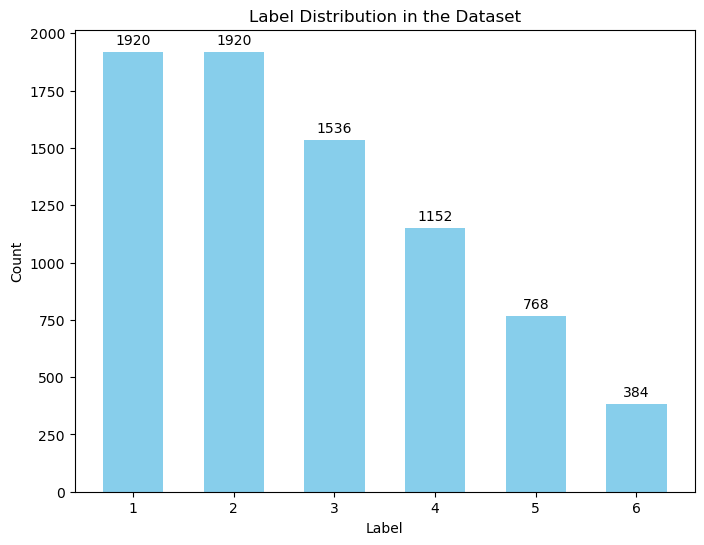

In [4]:
import matplotlib.pyplot as plt

import pandas as pd

# Assuming your `labels` array is already obtained
labels = np.array(labels).astype(int).tolist()

# Create a DataFrame and count the values
label_counts = pd.DataFrame(labels).value_counts().reset_index(name='Count')
label_counts.columns = ['Label', 'Count']

# Visualize the distribution using a bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts['Label'], label_counts['Count'], color='skyblue', width=0.6)

# Add the count values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, int(yval), ha='center', va='bottom')

plt.title('Label Distribution in the Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [5]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torchvision.models as models
import timm
from tqdm import tqdm  # For progress bar
# Set device for training (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Function to augment the images for block stability
def augment_image_cv2(image):
    # Random horizontal flip (optional)
    if random.random() > 0.5:
        image = cv2.flip(image, 1)

    # Random brightness adjustment
    brightness_factor = random.uniform(0.8, 1.2)  # Slightly wider range
    image = np.clip(image * brightness_factor, 0, 255).astype(np.uint8)

    # Random contrast adjustment
    if random.random() > 0.5:
        alpha = random.uniform(0.7, 1.3)  # Contrast factor
        image = np.clip(alpha * image, 0, 255).astype(np.uint8)

    # Random saturation adjustment
    if random.random() > 0.5:
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv_image[:, :, 1] = hsv_image[:, :, 1] * random.uniform(0.7, 1.3)  # Adjust saturation
        hsv_image[:, :, 1] = np.clip(hsv_image[:, :, 1], 0, 255)
        image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

    # Random brightness and contrast adjustment
    if random.random() > 0.5:
        beta = random.randint(-10, 10)  # Brightness offset
        image = np.clip(image + beta, 0, 255).astype(np.uint8)

    # Add Gaussian noise
    if random.random() > 0.5:  # Chance to add noise
        noise = np.random.randn(*image.shape) * 4.0  # Adjusted stddev
        image = np.clip(image + noise, 0, 255).astype(np.uint8)

    # Random rotation
    if random.random() > 0.5:
        angle = random.uniform(-10, 10)  # Rotation angle
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
        image = cv2.warpAffine(image, M, (w, h))

    return image

In [7]:
def balance_classes(filenames, labels, output_folder='augmented_images'):
    """ Balance the dataset by augmenting all minority classes """
    class_counts = Counter(labels)
    max_class_count = max(class_counts.values())

    # Create output folder for augmented images
    os.makedirs(output_folder, exist_ok=True)

    # Initialize lists to store new filenames and labels
    balanced_filenames = []
    balanced_labels = []

    # Loop over each class and balance it
    for class_label, count in class_counts.items():
        class_filenames = [fname for fname, label in zip(filenames, labels) if label == class_label]
        balanced_filenames.extend(class_filenames)
        balanced_labels.extend([class_label] * len(class_filenames))

        # Calculate how many more samples are needed to balance the dataset
        difference = max_class_count - count
        augmented_filenames = []
        augmented_labels = []

        # Augment the minority class images and save them to the new folder
        while difference > 0:
            for fname in class_filenames:
                image = cv2.imread(fname)
                augmented_image = augment_image_cv2(image)

                # Create a new filename for the augmented image
                base_name = os.path.basename(fname)
                new_filename = os.path.join(output_folder, f'aug_{difference}_{base_name}')

                # Save the augmented image
                cv2.imwrite(new_filename, augmented_image)

                augmented_filenames.append(new_filename)  # Store the new filename
                augmented_labels.append(class_label)
                difference -= 1
                if difference <= 0:
                    break

        # Add augmented images and labels to the dataset
        balanced_filenames.extend(augmented_filenames)
        balanced_labels.extend(augmented_labels)

    return balanced_filenames, balanced_labels

In [8]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and validation sets
train_filenames, val_filenames, train_labels, val_labels = train_test_split(
    filenames, labels, test_size=0.2, stratify=labels, random_state=42)

# Balance the training dataset by augmenting the minority class
train_balanced_filenames, train_balanced_labels = balance_classes(train_filenames, train_labels)

print(f'Training dataset:\t\t {Counter(train_labels)}')
print()
print(f'Balanced Training dataset:\t {Counter(train_balanced_labels)}')
print(f'Validation dataset:\t\t {Counter(val_labels)}')

Training dataset:		 Counter({1: 1536, 2: 1536, 3: 1229, 4: 922, 5: 614, 6: 307})

Balanced Training dataset:	 Counter({1: 1536, 4: 1536, 3: 1536, 2: 1536, 5: 1536, 6: 1536})
Validation dataset:		 Counter({1: 384, 2: 384, 3: 307, 4: 230, 5: 154, 6: 77})


In [9]:
class CustomCV2Dataset(Dataset):
    def __init__(self, filenames, labels):
        self.filenames = filenames
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Convert to tensor
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load image using OpenCV
        image = cv2.imread(self.filenames[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

        # Convert the image to tensor and normalize
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Create datasets with balanced data
# train_dataset = CustomCV2Dataset(train_filenames, train_labels)
train_dataset = CustomCV2Dataset(train_balanced_filenames, train_balanced_labels)
val_dataset = CustomCV2Dataset(val_filenames, val_labels)  # Use the original validation data

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [10]:
# # Model 1: Self made
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)  # Output: (32, 224, 224)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)  # Output: (64, 112, 112)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Output: (128, 56, 56)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling
        self.dropout = nn.Dropout(p=0.3)  # 30% dropout

        # Calculate the flattened size for the fully connected layers
        self.flattened_size = self._get_flattened_size()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 512)  # First fully connected layer
        self.fc2 = nn.Linear(512, 256)  # Second fully connected layer
        self.fc3 = nn.Linear(256, 6)  # Output layer for 6 classes

        # Batch Normalization
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)

    def _get_flattened_size(self):
        # Create a dummy tensor to calculate the flattened size
        with torch.no_grad():
            x = torch.zeros(1, 3, 224, 224)  # Example input with correct dimensions (3 channels)
            x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Max Pooling
            x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Max Pooling
            x = self.pool(F.relu(self.conv3(x)))  # Conv3 + ReLU + Max Pooling
            return x.numel()  # Get the number of elements in the output tensor

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 + ReLU + Max Pooling
        x = self.dropout(x)  # Apply dropout during training
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 + ReLU + Max Pooling
        x = self.dropout(x)  # Apply dropout during training
        x = self.pool(F.relu(self.conv3(x)))  # Conv3 + ReLU + Max Pooling
        x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
        
        x = F.relu(self.fc1(x))  # First fully connected layer
        x = self.batch_norm1(x)  # Batch normalization
        x = self.dropout(x)  # Apply dropout during training
        
        x = F.relu(self.fc2(x))  # Second fully connected layer
        x = self.batch_norm2(x)  # Batch normalization
        x = self.dropout(x)  # Apply dropout during training
        
        x = self.fc3(x)  # Final output layer
        return x

In [11]:
## Model 2: EfficientNet
class EfficientNet(nn.Module):
    def __init__(self, num_classes=6):
        super(EfficientNet, self).__init__()
        
        # Load the pre-trained EfficientNet-B0 model
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        
        # Replace the classifier layer with a new one
        self.efficientnet.classifier = nn.Linear(self.efficientnet.classifier.in_features, num_classes)

        # Regularization
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        x = self.efficientnet(x)
        x= self.dropout(x)
        return x

In [36]:
## Model 3: inception_v3
class Inception_v3(nn.Module):
    def __init__(self, num_classes=6):
        super(Inception_v3, self).__init__()
        self.inception = timm.create_model("inception_v3", pretrained=True, num_classes=num_classes)

    def forward(self, x):
        x = nn.functional.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        outputs = self.inception(x)
        return outputs

In [26]:
## Model 4: inception_v4 with ImageNet
class Inception_v4_ImageNet(nn.Module):
    def __init__(self, num_classes=6):
        super(Inception_v4_ImageNet, self).__init__()
        self.inception = timm.create_model("inception_v4", pretrained=True, num_classes=num_classes)

    def forward(self, x):
        x = nn.functional.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        outputs = self.inception(x)
        return outputs

In [27]:
## Model 5: inception_v4 with inception_resnet_v2
class Inception_v4_Resnet_v2(nn.Module):
    def __init__(self, num_classes=6):
        super(Inception_v4_Resnet_v2, self).__init__()
        self.inception = timm.create_model("inception_resnet_v2", pretrained=True, num_classes=num_classes)

    def forward(self, x):
        x = nn.functional.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        outputs = self.inception(x)  # No need for .logits with timm models
        return outputs

In [48]:
import csv
import time

# Function to save history to a CSV file
def save_history_to_csv(history, model_name, output_dir='training_results'):
    os.makedirs(output_dir, exist_ok=True) 
    csv_file = os.path.join(output_dir, f"{model_name}_history.csv")
    
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(['Epoch', 'Train Loss', 'Val Loss', 'Train Acc', 'Val Acc'])
        # Write the epoch-by-epoch data without train time
        for epoch, train_loss, val_loss, train_acc, val_acc in zip(history['epochs'], 
                                                                   history['train_loss'], 
                                                                   history['val_loss'], 
                                                                   history['train_acc'], 
                                                                   history['val_acc']):
            writer.writerow([epoch, train_loss, val_loss, train_acc, val_acc])

        # Save the total train time in a separate row after all epochs are written
        writer.writerow(['Total Time', history['total_train_time']])

    print(f"History saved to {csv_file}")


# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name):
    # Dictionary to store the history of loss and accuracy
    history = {
        'epochs': [],
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'total_train_time': 0 
    }

    start_time = time.time()  # Start timing the training process
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Iterate over training data
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device).long()  # Move data to device

            # Adjust labels to start at 0
            labels = labels - 1  # Now labels range from 0 to 5

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize the model parameters

            running_loss += loss.item()  # Accumulate loss
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
            total_train += labels.size(0)  # Total samples
            correct_train += (predicted == labels).sum().item()  # Correct predictions

        # Calculate average loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # Validation loop (set model to eval mode)
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad(): # No gradient calculation in validation
            for val_data, val_labels in val_loader:
                val_data, val_labels = val_data.to(device), val_labels.to(device).long()  # Move data to device
                # Adjust labels to start at 0
                val_labels = val_labels - 1  # Now labels range from 0 to 5

                val_outputs = model(val_data)
                val_loss = criterion(val_outputs, val_labels)
                running_val_loss += val_loss.item()
        
                _, val_predicted = torch.max(val_outputs, 1)
                correct_val += (val_predicted == val_labels).sum().item()
                total_val += val_labels.size(0)
        # Calculate validation loss and accuracy
        val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val

        # Save epoch results to history dictionary
        history['epochs'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")
    
    # Store the total training time
    history['total_train_time'] = time.time() - start_time

    # Save the history to CSV
    save_history_to_csv(history, model_name)
    
    return history


In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weights
class_counts = torch.tensor([1920, 5760], dtype=torch.float32)  # Example counts for each class
class_weights = 1.0 / class_counts  # Calculate weights inversely proportional to class counts

weights = class_weights.to(device) 

# Training parameters
epochs = 20

# Define your models
model1 = CNN()
model2 = EfficientNet()
model3 = Inception_v3()
model4 = Inception_v4_ImageNet()
model5 = Inception_v4_Resnet_v2()

# Put them in a list along with their names
models = [('CNN', model1), ('EfficientNet', model2), ('Inception_v3', model3), ('Inception_v4_ImageNet', model4), ('Inception_v4_Resnet_v2', model5)]

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification

# Training parameters
epochs = 20

# Store the results for each model
results = []

# Train each model
for model_name, model in models:
    model.to(device)  # Move the model to the appropriate device
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Define the optimizer here
    print(f"Training model: {model_name}")
    hostory = train_model(model, train_loader, validation_loader, criterion, optimizer, epochs, model_name)
    results.append(hostory)

Training model: CNN


Training Epoch 1/20: 100%|██████████| 288/288 [00:07<00:00, 39.20it/s]

Epoch [1/20], Loss: 1.7091, Accuracy: 0.2623


Epoch 1/20 - Train Loss: 1.7091 - Train Acc: 0.2623 - Val Loss: 1.9861 - Val Acc: 0.2324


Training Epoch 2/20: 100%|██████████| 288/288 [00:07<00:00, 40.01it/s]

Epoch [2/20], Loss: 1.5946, Accuracy: 0.2878


Epoch 2/20 - Train Loss: 1.5946 - Train Acc: 0.2878 - Val Loss: 1.6807 - Val Acc: 0.2467


Training Epoch 3/20: 100%|██████████| 288/288 [00:10<00:00, 27.77it/s]

Epoch [3/20], Loss: 1.5526, Accuracy: 0.3028


Epoch 3/20 - Train Loss: 1.5526 - Train Acc: 0.3028 - Val Loss: 1.7247 - Val Acc: 0.2565


Training Epoch 4/20: 100%|██████████| 288/288 [00:07<00:00, 39.35it/s]

Epoch [4/20], Loss: 1.5366, Accuracy: 0.3083


Epoch 4/20 - Train Loss: 1.5366 - Train Acc: 0.3083 - Val Loss: 1.6831 - Val Acc: 0.2578


Training Epoch 5/20: 100%|██████████| 288/288 [00:07<00:00, 39.14it/s]

Epoch [5/20], Loss: 1.5496, Accuracy: 0.3081


Epoch 5/20 - Train Loss: 1.5496 - Train Acc: 0.3081 - Val Loss: 2.0018 - Val Acc: 0.2643


Training Epoch 6/20: 100%|██████████| 288/288 [00:07<00:00, 39.07it/s]

Epoch [6/20], Loss: 1.4753, Accuracy: 0.3319


Epoch 6/20 - Train Loss: 1.4753 - Train Acc: 0.3319 - Val Loss: 2.4908 - Val Acc: 0.2533


Training Epoch 7/20: 100%|██████████| 288/288 [00:10<00:00, 26.77it/s]

Epoch [7/20], Loss: 1.4514, Accuracy: 0.3512


Epoch 7/20 - Train Loss: 1.4514 - Train Acc: 0.3512 - Val Loss: 1.5911 - Val Acc: 0.2637


Training Epoch 8/20: 100%|██████████| 288/288 [00:14<00:00, 19.28it/s]

Epoch [8/20], Loss: 1.4129, Accuracy: 0.3760


Epoch 8/20 - Train Loss: 1.4129 - Train Acc: 0.3760 - Val Loss: 2.1784 - Val Acc: 0.2650


Training Epoch 9/20: 100%|██████████| 288/288 [00:11<00:00, 24.71it/s]

Epoch [9/20], Loss: 1.3667, Accuracy: 0.4113


Epoch 9/20 - Train Loss: 1.3667 - Train Acc: 0.4113 - Val Loss: 1.8370 - Val Acc: 0.2780


Training Epoch 10/20: 100%|██████████| 288/288 [00:11<00:00, 24.58it/s]

Epoch [10/20], Loss: 1.4087, Accuracy: 0.3860


Epoch 10/20 - Train Loss: 1.4087 - Train Acc: 0.3860 - Val Loss: 1.9984 - Val Acc: 0.2695


Training Epoch 11/20: 100%|██████████| 288/288 [00:10<00:00, 26.50it/s]

Epoch [11/20], Loss: 1.3007, Accuracy: 0.4473


Epoch 11/20 - Train Loss: 1.3007 - Train Acc: 0.4473 - Val Loss: 2.7148 - Val Acc: 0.2826


Training Epoch 12/20: 100%|██████████| 288/288 [00:10<00:00, 26.69it/s]

Epoch [12/20], Loss: 1.2031, Accuracy: 0.4974


Epoch 12/20 - Train Loss: 1.2031 - Train Acc: 0.4974 - Val Loss: 2.4712 - Val Acc: 0.2839


Training Epoch 13/20: 100%|██████████| 288/288 [00:10<00:00, 26.71it/s]

Epoch [13/20], Loss: 1.1045, Accuracy: 0.5428


Epoch 13/20 - Train Loss: 1.1045 - Train Acc: 0.5428 - Val Loss: 2.4485 - Val Acc: 0.2826


Training Epoch 14/20: 100%|██████████| 288/288 [00:09<00:00, 29.05it/s]

Epoch [14/20], Loss: 0.9779, Accuracy: 0.6156


Epoch 14/20 - Train Loss: 0.9779 - Train Acc: 0.6156 - Val Loss: 2.0579 - Val Acc: 0.2910


Training Epoch 15/20: 100%|██████████| 288/288 [00:07<00:00, 39.75it/s]

Epoch [15/20], Loss: 0.8354, Accuracy: 0.6760


Epoch 15/20 - Train Loss: 0.8354 - Train Acc: 0.6760 - Val Loss: 3.9350 - Val Acc: 0.2786


Training Epoch 16/20: 100%|██████████| 288/288 [00:10<00:00, 26.71it/s]

Epoch [16/20], Loss: 0.7511, Accuracy: 0.7104


Epoch 16/20 - Train Loss: 0.7511 - Train Acc: 0.7104 - Val Loss: 2.9804 - Val Acc: 0.2943


Training Epoch 17/20: 100%|██████████| 288/288 [00:10<00:00, 26.51it/s]

Epoch [17/20], Loss: 0.5836, Accuracy: 0.7769


Epoch 17/20 - Train Loss: 0.5836 - Train Acc: 0.7769 - Val Loss: 2.9356 - Val Acc: 0.2734


Training Epoch 18/20: 100%|██████████| 288/288 [00:14<00:00, 19.84it/s]

Epoch [18/20], Loss: 0.4438, Accuracy: 0.8422


Epoch 18/20 - Train Loss: 0.4438 - Train Acc: 0.8422 - Val Loss: 2.6887 - Val Acc: 0.2826


Training Epoch 19/20: 100%|██████████| 288/288 [00:11<00:00, 25.39it/s]

Epoch [19/20], Loss: 0.4295, Accuracy: 0.8446


Epoch 19/20 - Train Loss: 0.4295 - Train Acc: 0.8446 - Val Loss: 2.8025 - Val Acc: 0.2904


Training Epoch 20/20: 100%|██████████| 288/288 [00:07<00:00, 38.04it/s]

Epoch [20/20], Loss: 0.3781, Accuracy: 0.8570


Epoch 20/20 - Train Loss: 0.3781 - Train Acc: 0.8570 - Val Loss: 3.2234 - Val Acc: 0.2708
History saved to training_results/CNN_history.csv
Training model: EfficientNet


Training Epoch 1/20: 100%|██████████| 288/288 [00:10<00:00, 27.02it/s]

Epoch [1/20], Loss: 1.4990, Accuracy: 0.3559


Epoch 1/20 - Train Loss: 1.4990 - Train Acc: 0.3559 - Val Loss: 1.3196 - Val Acc: 0.4225


Training Epoch 2/20: 100%|██████████| 288/288 [00:10<00:00, 27.52it/s]

Epoch [2/20], Loss: 1.3182, Accuracy: 0.4474


Epoch 2/20 - Train Loss: 1.3182 - Train Acc: 0.4474 - Val Loss: 1.2773 - Val Acc: 0.4629


Training Epoch 3/20: 100%|██████████| 288/288 [00:14<00:00, 19.92it/s]

Epoch [3/20], Loss: 1.2153, Accuracy: 0.4941


Epoch 3/20 - Train Loss: 1.2153 - Train Acc: 0.4941 - Val Loss: 1.1709 - Val Acc: 0.5221


Training Epoch 4/20: 100%|██████████| 288/288 [00:14<00:00, 19.75it/s]

Epoch [4/20], Loss: 1.0976, Accuracy: 0.5483


Epoch 4/20 - Train Loss: 1.0976 - Train Acc: 0.5483 - Val Loss: 1.1600 - Val Acc: 0.5130


Training Epoch 5/20: 100%|██████████| 288/288 [00:15<00:00, 18.35it/s]

Epoch [5/20], Loss: 1.0284, Accuracy: 0.5788


Epoch 5/20 - Train Loss: 1.0284 - Train Acc: 0.5788 - Val Loss: 1.1034 - Val Acc: 0.5618


Training Epoch 6/20: 100%|██████████| 288/288 [00:22<00:00, 12.88it/s]

Epoch [6/20], Loss: 0.9450, Accuracy: 0.6058


Epoch 6/20 - Train Loss: 0.9450 - Train Acc: 0.6058 - Val Loss: 1.1471 - Val Acc: 0.5658


Training Epoch 7/20: 100%|██████████| 288/288 [00:15<00:00, 18.32it/s]

Epoch [7/20], Loss: 0.8690, Accuracy: 0.6391


Epoch 7/20 - Train Loss: 0.8690 - Train Acc: 0.6391 - Val Loss: 1.1264 - Val Acc: 0.5781


Training Epoch 8/20: 100%|██████████| 288/288 [00:15<00:00, 18.70it/s]

Epoch [8/20], Loss: 0.8079, Accuracy: 0.6724


Epoch 8/20 - Train Loss: 0.8079 - Train Acc: 0.6724 - Val Loss: 1.1160 - Val Acc: 0.5794


Training Epoch 9/20: 100%|██████████| 288/288 [00:18<00:00, 15.53it/s]

Epoch [9/20], Loss: 0.7233, Accuracy: 0.6979


Epoch 9/20 - Train Loss: 0.7233 - Train Acc: 0.6979 - Val Loss: 1.2861 - Val Acc: 0.5768


Training Epoch 10/20: 100%|██████████| 288/288 [00:18<00:00, 15.64it/s]

Epoch [10/20], Loss: 0.6647, Accuracy: 0.7198


Epoch 10/20 - Train Loss: 0.6647 - Train Acc: 0.7198 - Val Loss: 1.2622 - Val Acc: 0.5853


Training Epoch 11/20: 100%|██████████| 288/288 [00:18<00:00, 15.31it/s]

Epoch [11/20], Loss: 0.6286, Accuracy: 0.7259


Epoch 11/20 - Train Loss: 0.6286 - Train Acc: 0.7259 - Val Loss: 1.2661 - Val Acc: 0.5690


Training Epoch 12/20: 100%|██████████| 288/288 [00:18<00:00, 15.77it/s]

Epoch [12/20], Loss: 0.5516, Accuracy: 0.7617


Epoch 12/20 - Train Loss: 0.5516 - Train Acc: 0.7617 - Val Loss: 1.3523 - Val Acc: 0.5599


Training Epoch 13/20: 100%|██████████| 288/288 [00:18<00:00, 15.91it/s]

Epoch [13/20], Loss: 0.5301, Accuracy: 0.7665


Epoch 13/20 - Train Loss: 0.5301 - Train Acc: 0.7665 - Val Loss: 1.4130 - Val Acc: 0.5892


Training Epoch 14/20: 100%|██████████| 288/288 [00:10<00:00, 27.01it/s]

Epoch [14/20], Loss: 0.4766, Accuracy: 0.7843


Epoch 14/20 - Train Loss: 0.4766 - Train Acc: 0.7843 - Val Loss: 1.5636 - Val Acc: 0.5658


Training Epoch 15/20: 100%|██████████| 288/288 [00:17<00:00, 16.02it/s]

Epoch [15/20], Loss: 0.4589, Accuracy: 0.7894


Epoch 15/20 - Train Loss: 0.4589 - Train Acc: 0.7894 - Val Loss: 1.5345 - Val Acc: 0.5651


Training Epoch 16/20: 100%|██████████| 288/288 [00:18<00:00, 15.96it/s]

Epoch [16/20], Loss: 0.4429, Accuracy: 0.7980


Epoch 16/20 - Train Loss: 0.4429 - Train Acc: 0.7980 - Val Loss: 1.7169 - Val Acc: 0.5736


Training Epoch 17/20: 100%|██████████| 288/288 [00:18<00:00, 15.88it/s]

Epoch [17/20], Loss: 0.4169, Accuracy: 0.8026


Epoch 17/20 - Train Loss: 0.4169 - Train Acc: 0.8026 - Val Loss: 1.7347 - Val Acc: 0.5638


Training Epoch 18/20: 100%|██████████| 288/288 [00:18<00:00, 15.87it/s]

Epoch [18/20], Loss: 0.4163, Accuracy: 0.8011


Epoch 18/20 - Train Loss: 0.4163 - Train Acc: 0.8011 - Val Loss: 1.7806 - Val Acc: 0.5553


Training Epoch 19/20: 100%|██████████| 288/288 [00:11<00:00, 25.07it/s]

Epoch [19/20], Loss: 0.3947, Accuracy: 0.8072


Epoch 19/20 - Train Loss: 0.3947 - Train Acc: 0.8072 - Val Loss: 1.7111 - Val Acc: 0.5762


Training Epoch 20/20: 100%|██████████| 288/288 [00:16<00:00, 17.75it/s]

Epoch [20/20], Loss: 0.3907, Accuracy: 0.8022


Epoch 20/20 - Train Loss: 0.3907 - Train Acc: 0.8022 - Val Loss: 2.0521 - Val Acc: 0.5469
History saved to training_results/EfficientNet_history.csv
Training model: Inception_v3


Training Epoch 1/20: 100%|██████████| 288/288 [00:19<00:00, 14.52it/s]

Epoch [1/20], Loss: 1.5673, Accuracy: 0.3564


Epoch 1/20 - Train Loss: 1.5673 - Train Acc: 0.3564 - Val Loss: 1.4870 - Val Acc: 0.3685


Training Epoch 2/20: 100%|██████████| 288/288 [00:27<00:00, 10.29it/s]

Epoch [2/20], Loss: 1.2382, Accuracy: 0.4821


Epoch 2/20 - Train Loss: 1.2382 - Train Acc: 0.4821 - Val Loss: 1.2664 - Val Acc: 0.4850


Training Epoch 3/20: 100%|██████████| 288/288 [00:19<00:00, 14.67it/s]

Epoch [3/20], Loss: 1.0821, Accuracy: 0.5616


Epoch 3/20 - Train Loss: 1.0821 - Train Acc: 0.5616 - Val Loss: 1.1930 - Val Acc: 0.4987


Training Epoch 4/20: 100%|██████████| 288/288 [00:22<00:00, 12.67it/s]

Epoch [4/20], Loss: 0.9593, Accuracy: 0.6237


Epoch 4/20 - Train Loss: 0.9593 - Train Acc: 0.6237 - Val Loss: 1.1138 - Val Acc: 0.5742


Training Epoch 5/20: 100%|██████████| 288/288 [00:24<00:00, 11.95it/s]

Epoch [5/20], Loss: 0.8761, Accuracy: 0.6625


Epoch 5/20 - Train Loss: 0.8761 - Train Acc: 0.6625 - Val Loss: 1.1837 - Val Acc: 0.5488


Training Epoch 6/20: 100%|██████████| 288/288 [00:26<00:00, 10.87it/s]


Epoch [6/20], Loss: 0.7941, Accuracy: 0.6961
Epoch 6/20 - Train Loss: 0.7941 - Train Acc: 0.6961 - Val Loss: 0.9956 - Val Acc: 0.6016


Training Epoch 7/20: 100%|██████████| 288/288 [00:24<00:00, 11.88it/s]

Epoch [7/20], Loss: 0.7489, Accuracy: 0.7186


Epoch 7/20 - Train Loss: 0.7489 - Train Acc: 0.7186 - Val Loss: 1.1029 - Val Acc: 0.5820


Training Epoch 8/20: 100%|██████████| 288/288 [00:27<00:00, 10.64it/s]

Epoch [8/20], Loss: 0.6875, Accuracy: 0.7426


Epoch 8/20 - Train Loss: 0.6875 - Train Acc: 0.7426 - Val Loss: 1.2495 - Val Acc: 0.5475


Training Epoch 9/20: 100%|██████████| 288/288 [00:25<00:00, 11.16it/s]

Epoch [9/20], Loss: 0.6079, Accuracy: 0.7747


Epoch 9/20 - Train Loss: 0.6079 - Train Acc: 0.7747 - Val Loss: 1.1180 - Val Acc: 0.5964


Training Epoch 10/20: 100%|██████████| 288/288 [00:29<00:00,  9.81it/s]

Epoch [10/20], Loss: 0.5404, Accuracy: 0.8023


Epoch 10/20 - Train Loss: 0.5404 - Train Acc: 0.8023 - Val Loss: 1.1342 - Val Acc: 0.6003


Training Epoch 11/20: 100%|██████████| 288/288 [00:25<00:00, 11.17it/s]

Epoch [11/20], Loss: 0.4728, Accuracy: 0.8241


Epoch 11/20 - Train Loss: 0.4728 - Train Acc: 0.8241 - Val Loss: 1.2188 - Val Acc: 0.6243


Training Epoch 12/20: 100%|██████████| 288/288 [00:23<00:00, 12.37it/s]

Epoch [12/20], Loss: 0.4254, Accuracy: 0.8467


Epoch 12/20 - Train Loss: 0.4254 - Train Acc: 0.8467 - Val Loss: 1.0886 - Val Acc: 0.6263


Training Epoch 13/20: 100%|██████████| 288/288 [00:24<00:00, 12.00it/s]

Epoch [13/20], Loss: 0.3760, Accuracy: 0.8618


Epoch 13/20 - Train Loss: 0.3760 - Train Acc: 0.8618 - Val Loss: 1.2503 - Val Acc: 0.5977


Training Epoch 14/20: 100%|██████████| 288/288 [00:22<00:00, 12.85it/s]

Epoch [14/20], Loss: 0.3461, Accuracy: 0.8772


Epoch 14/20 - Train Loss: 0.3461 - Train Acc: 0.8772 - Val Loss: 1.4190 - Val Acc: 0.6074


Training Epoch 15/20: 100%|██████████| 288/288 [00:18<00:00, 15.36it/s]

Epoch [15/20], Loss: 0.2772, Accuracy: 0.9023


Epoch 15/20 - Train Loss: 0.2772 - Train Acc: 0.9023 - Val Loss: 1.4693 - Val Acc: 0.6335


Training Epoch 16/20: 100%|██████████| 288/288 [00:18<00:00, 15.49it/s]

Epoch [16/20], Loss: 0.2410, Accuracy: 0.9140


Epoch 16/20 - Train Loss: 0.2410 - Train Acc: 0.9140 - Val Loss: 1.4521 - Val Acc: 0.6198


Training Epoch 17/20: 100%|██████████| 288/288 [00:18<00:00, 15.55it/s]

Epoch [17/20], Loss: 0.2065, Accuracy: 0.9264


Epoch 17/20 - Train Loss: 0.2065 - Train Acc: 0.9264 - Val Loss: 1.4400 - Val Acc: 0.6172


Training Epoch 18/20: 100%|██████████| 288/288 [00:25<00:00, 11.15it/s]

Epoch [18/20], Loss: 0.1919, Accuracy: 0.9324


Epoch 18/20 - Train Loss: 0.1919 - Train Acc: 0.9324 - Val Loss: 1.5475 - Val Acc: 0.6107


Training Epoch 19/20: 100%|██████████| 288/288 [00:32<00:00,  8.74it/s]

Epoch [19/20], Loss: 0.1877, Accuracy: 0.9321


Epoch 19/20 - Train Loss: 0.1877 - Train Acc: 0.9321 - Val Loss: 1.7211 - Val Acc: 0.5892


Training Epoch 20/20: 100%|██████████| 288/288 [00:25<00:00, 11.10it/s]


Epoch [20/20], Loss: 0.1349, Accuracy: 0.9546
Epoch 20/20 - Train Loss: 0.1349 - Train Acc: 0.9546 - Val Loss: 1.7964 - Val Acc: 0.6113
History saved to training_results/Inception_v3_history.csv
Training model: Inception_v4_ImageNet


Training Epoch 1/20: 100%|██████████| 288/288 [00:44<00:00,  6.43it/s]


Epoch [1/20], Loss: 1.5394, Accuracy: 0.2958
Epoch 1/20 - Train Loss: 1.5394 - Train Acc: 0.2958 - Val Loss: 1.5912 - Val Acc: 0.2441


Training Epoch 2/20: 100%|██████████| 288/288 [00:48<00:00,  5.98it/s]

Epoch [2/20], Loss: 1.4432, Accuracy: 0.3343


Epoch 2/20 - Train Loss: 1.4432 - Train Acc: 0.3343 - Val Loss: 1.8952 - Val Acc: 0.2318


Training Epoch 3/20: 100%|██████████| 288/288 [00:39<00:00,  7.29it/s]

Epoch [3/20], Loss: 1.3974, Accuracy: 0.3608


Epoch 3/20 - Train Loss: 1.3974 - Train Acc: 0.3608 - Val Loss: 1.7319 - Val Acc: 0.2832


Training Epoch 4/20: 100%|██████████| 288/288 [00:47<00:00,  6.08it/s]

Epoch [4/20], Loss: 1.3161, Accuracy: 0.4234


Epoch 4/20 - Train Loss: 1.3161 - Train Acc: 0.4234 - Val Loss: 1.5627 - Val Acc: 0.3092


Training Epoch 5/20: 100%|██████████| 288/288 [00:37<00:00,  7.77it/s]

Epoch [5/20], Loss: 1.2294, Accuracy: 0.4810


Epoch 5/20 - Train Loss: 1.2294 - Train Acc: 0.4810 - Val Loss: 1.2695 - Val Acc: 0.4714


Training Epoch 6/20: 100%|██████████| 288/288 [00:41<00:00,  6.93it/s]

Epoch [6/20], Loss: 1.1463, Accuracy: 0.5312


Epoch 6/20 - Train Loss: 1.1463 - Train Acc: 0.5312 - Val Loss: 1.2296 - Val Acc: 0.4928


Training Epoch 7/20: 100%|██████████| 288/288 [00:33<00:00,  8.50it/s]

Epoch [7/20], Loss: 1.0532, Accuracy: 0.5689


Epoch 7/20 - Train Loss: 1.0532 - Train Acc: 0.5689 - Val Loss: 1.1604 - Val Acc: 0.5254


Training Epoch 8/20: 100%|██████████| 288/288 [00:34<00:00,  8.32it/s]

Epoch [8/20], Loss: 0.9973, Accuracy: 0.5982


Epoch 8/20 - Train Loss: 0.9973 - Train Acc: 0.5982 - Val Loss: 1.1049 - Val Acc: 0.5658


Training Epoch 9/20: 100%|██████████| 288/288 [00:46<00:00,  6.15it/s]

Epoch [9/20], Loss: 0.9423, Accuracy: 0.6293


Epoch 9/20 - Train Loss: 0.9423 - Train Acc: 0.6293 - Val Loss: 1.0701 - Val Acc: 0.5749


Training Epoch 10/20: 100%|██████████| 288/288 [00:49<00:00,  5.76it/s]

Epoch [10/20], Loss: 0.8802, Accuracy: 0.6595


Epoch 10/20 - Train Loss: 0.8802 - Train Acc: 0.6595 - Val Loss: 1.0889 - Val Acc: 0.5833


Training Epoch 11/20: 100%|██████████| 288/288 [00:39<00:00,  7.21it/s]

Epoch [11/20], Loss: 0.8227, Accuracy: 0.6811


Epoch 11/20 - Train Loss: 0.8227 - Train Acc: 0.6811 - Val Loss: 1.1564 - Val Acc: 0.5423


Training Epoch 12/20: 100%|██████████| 288/288 [00:48<00:00,  5.96it/s]

Epoch [12/20], Loss: 0.7614, Accuracy: 0.7107


Epoch 12/20 - Train Loss: 0.7614 - Train Acc: 0.7107 - Val Loss: 1.0643 - Val Acc: 0.5820


Training Epoch 13/20: 100%|██████████| 288/288 [00:45<00:00,  6.40it/s]

Epoch [13/20], Loss: 0.7046, Accuracy: 0.7324


Epoch 13/20 - Train Loss: 0.7046 - Train Acc: 0.7324 - Val Loss: 1.1464 - Val Acc: 0.5866


Training Epoch 14/20: 100%|██████████| 288/288 [00:45<00:00,  6.31it/s]

Epoch [14/20], Loss: 0.6574, Accuracy: 0.7567


Epoch 14/20 - Train Loss: 0.6574 - Train Acc: 0.7567 - Val Loss: 1.1952 - Val Acc: 0.5898


Training Epoch 15/20: 100%|██████████| 288/288 [00:38<00:00,  7.54it/s]

Epoch [15/20], Loss: 0.5790, Accuracy: 0.7839


Epoch 15/20 - Train Loss: 0.5790 - Train Acc: 0.7839 - Val Loss: 1.1624 - Val Acc: 0.6055


Training Epoch 16/20: 100%|██████████| 288/288 [00:33<00:00,  8.54it/s]

Epoch [16/20], Loss: 0.5176, Accuracy: 0.8158


Epoch 16/20 - Train Loss: 0.5176 - Train Acc: 0.8158 - Val Loss: 1.1847 - Val Acc: 0.5990


Training Epoch 17/20: 100%|██████████| 288/288 [00:44<00:00,  6.42it/s]

Epoch [17/20], Loss: 0.4761, Accuracy: 0.8298


Epoch 17/20 - Train Loss: 0.4761 - Train Acc: 0.8298 - Val Loss: 1.1799 - Val Acc: 0.6087


Training Epoch 18/20: 100%|██████████| 288/288 [00:48<00:00,  5.98it/s]

Epoch [18/20], Loss: 0.4260, Accuracy: 0.8460


Epoch 18/20 - Train Loss: 0.4260 - Train Acc: 0.8460 - Val Loss: 1.3857 - Val Acc: 0.5729


Training Epoch 19/20: 100%|██████████| 288/288 [00:45<00:00,  6.39it/s]

Epoch [19/20], Loss: 0.3641, Accuracy: 0.8734


Epoch 19/20 - Train Loss: 0.3641 - Train Acc: 0.8734 - Val Loss: 1.3863 - Val Acc: 0.5872


Training Epoch 20/20: 100%|██████████| 288/288 [00:40<00:00,  7.09it/s]

Epoch [20/20], Loss: 0.3291, Accuracy: 0.8835


Epoch 20/20 - Train Loss: 0.3291 - Train Acc: 0.8835 - Val Loss: 1.7145 - Val Acc: 0.5638
History saved to training_results/Inception_v4_ImageNet_history.csv
Training model: Inception_v4_Resnet_v2


Training Epoch 1/20: 100%|██████████| 288/288 [01:02<00:00,  4.58it/s]

Epoch [1/20], Loss: 1.4308, Accuracy: 0.3661


Epoch 1/20 - Train Loss: 1.4308 - Train Acc: 0.3661 - Val Loss: 1.8638 - Val Acc: 0.3411


Training Epoch 2/20: 100%|██████████| 288/288 [01:02<00:00,  4.59it/s]


Epoch [2/20], Loss: 1.2217, Accuracy: 0.4867
Epoch 2/20 - Train Loss: 1.2217 - Train Acc: 0.4867 - Val Loss: 1.2347 - Val Acc: 0.5137


Training Epoch 3/20: 100%|██████████| 288/288 [01:06<00:00,  4.35it/s]

Epoch [3/20], Loss: 1.0664, Accuracy: 0.5699


Epoch 3/20 - Train Loss: 1.0664 - Train Acc: 0.5699 - Val Loss: 1.2314 - Val Acc: 0.5130


Training Epoch 4/20: 100%|██████████| 288/288 [00:51<00:00,  5.64it/s]


Epoch [4/20], Loss: 0.9537, Accuracy: 0.6235
Epoch 4/20 - Train Loss: 0.9537 - Train Acc: 0.6235 - Val Loss: 1.1905 - Val Acc: 0.5299


Training Epoch 5/20: 100%|██████████| 288/288 [00:58<00:00,  4.96it/s]

Epoch [5/20], Loss: 0.8450, Accuracy: 0.6738


Epoch 5/20 - Train Loss: 0.8450 - Train Acc: 0.6738 - Val Loss: 1.0419 - Val Acc: 0.6016


Training Epoch 6/20: 100%|██████████| 288/288 [00:40<00:00,  7.15it/s]


Epoch [6/20], Loss: 0.7532, Accuracy: 0.7167
Epoch 6/20 - Train Loss: 0.7532 - Train Acc: 0.7167 - Val Loss: 0.9882 - Val Acc: 0.6230


Training Epoch 7/20: 100%|██████████| 288/288 [00:40<00:00,  7.12it/s]


Epoch [7/20], Loss: 0.6668, Accuracy: 0.7492
Epoch 7/20 - Train Loss: 0.6668 - Train Acc: 0.7492 - Val Loss: 1.0491 - Val Acc: 0.5983


Training Epoch 8/20: 100%|██████████| 288/288 [00:41<00:00,  6.99it/s]


Epoch [8/20], Loss: 0.5790, Accuracy: 0.7892
Epoch 8/20 - Train Loss: 0.5790 - Train Acc: 0.7892 - Val Loss: 1.0421 - Val Acc: 0.6211


Training Epoch 9/20: 100%|██████████| 288/288 [00:43<00:00,  6.59it/s]


Epoch [9/20], Loss: 0.4969, Accuracy: 0.8173
Epoch 9/20 - Train Loss: 0.4969 - Train Acc: 0.8173 - Val Loss: 1.0304 - Val Acc: 0.6432


Training Epoch 10/20: 100%|██████████| 288/288 [00:51<00:00,  5.64it/s]

Epoch [10/20], Loss: 0.3973, Accuracy: 0.8601


Epoch 10/20 - Train Loss: 0.3973 - Train Acc: 0.8601 - Val Loss: 1.2430 - Val Acc: 0.6230


Training Epoch 11/20: 100%|██████████| 288/288 [00:40<00:00,  7.13it/s]


Epoch [11/20], Loss: 0.3476, Accuracy: 0.8737
Epoch 11/20 - Train Loss: 0.3476 - Train Acc: 0.8737 - Val Loss: 1.1863 - Val Acc: 0.6387


Training Epoch 12/20: 100%|██████████| 288/288 [01:05<00:00,  4.43it/s]


Epoch [12/20], Loss: 0.2749, Accuracy: 0.9015
Epoch 12/20 - Train Loss: 0.2749 - Train Acc: 0.9015 - Val Loss: 1.2807 - Val Acc: 0.6380


Training Epoch 13/20: 100%|██████████| 288/288 [01:02<00:00,  4.62it/s]

Epoch [13/20], Loss: 0.2244, Accuracy: 0.9223


Epoch 13/20 - Train Loss: 0.2244 - Train Acc: 0.9223 - Val Loss: 1.5722 - Val Acc: 0.6107


Training Epoch 14/20: 100%|██████████| 288/288 [01:02<00:00,  4.59it/s]

Epoch [14/20], Loss: 0.1738, Accuracy: 0.9401


Epoch 14/20 - Train Loss: 0.1738 - Train Acc: 0.9401 - Val Loss: 1.6182 - Val Acc: 0.6159


Training Epoch 15/20: 100%|██████████| 288/288 [00:55<00:00,  5.22it/s]


Epoch [15/20], Loss: 0.1605, Accuracy: 0.9428
Epoch 15/20 - Train Loss: 0.1605 - Train Acc: 0.9428 - Val Loss: 1.7880 - Val Acc: 0.6133


Training Epoch 16/20: 100%|██████████| 288/288 [00:40<00:00,  7.13it/s]


Epoch [16/20], Loss: 0.1239, Accuracy: 0.9584
Epoch 16/20 - Train Loss: 0.1239 - Train Acc: 0.9584 - Val Loss: 1.6196 - Val Acc: 0.6263


Training Epoch 17/20: 100%|██████████| 288/288 [00:43<00:00,  6.58it/s]


Epoch [17/20], Loss: 0.1305, Accuracy: 0.9549
Epoch 17/20 - Train Loss: 0.1305 - Train Acc: 0.9549 - Val Loss: 1.9569 - Val Acc: 0.6035


Training Epoch 18/20: 100%|██████████| 288/288 [00:49<00:00,  5.82it/s]

Epoch [18/20], Loss: 0.1181, Accuracy: 0.9588


Epoch 18/20 - Train Loss: 0.1181 - Train Acc: 0.9588 - Val Loss: 1.9844 - Val Acc: 0.6113


Training Epoch 19/20: 100%|██████████| 288/288 [00:45<00:00,  6.31it/s]


Epoch [19/20], Loss: 0.0951, Accuracy: 0.9688
Epoch 19/20 - Train Loss: 0.0951 - Train Acc: 0.9688 - Val Loss: 1.9686 - Val Acc: 0.6283


Training Epoch 20/20: 100%|██████████| 288/288 [00:40<00:00,  7.16it/s]


Epoch [20/20], Loss: 0.0787, Accuracy: 0.9716
Epoch 20/20 - Train Loss: 0.0787 - Train Acc: 0.9716 - Val Loss: 1.7843 - Val Acc: 0.6224
History saved to training_results/Inception_v4_Resnet_v2_history.csv


In [50]:
testPath = 'COMP90086_2024_Project_test'
testFile = 'test.csv'

test_filenames, _ = getFilenames(testPath, testFile, 'test')
# Create test dataset and dataloader
test_dataset = CustomCV2Dataset(test_filenames, [1] * len(test_filenames))  # Use the original validation data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

1000 / 1920 : 525774
1920 / 1920 : 999651


In [51]:
def test_and_save(model, model_name):
    # Set model to evaluation mode
    model.eval()

    # Store predictions
    predictions = []

    # No need to calculate gradients during inference
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            images = images.float()  # Ensure the input is of type float32
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the index of the highest score
            predicted = predicted + 1
            predictions.extend(predicted.cpu().numpy())  # Store the predictions

    # Now `predictions` will contain the predicted labels for the test images
    test_path = os.path.join(testPath, testFile)
    test_pred = pd.read_csv(test_path)
    test_pred['stable_height'] = predictions

    # Create the predictions directory if it doesn't exist
    os.makedirs('predictions', exist_ok=True)

    # Save the predictions in the 'predictions' directory
    test_pred.set_index('id').to_csv(f'predictions/predictions_{model_name}.csv')

# Test each model and save the predictions
for model_name, model in models:
    test_and_save(model, model_name)